# Sales Data Analysis & Forecasting
This notebook reproduces the provided sales analysis: load data, clean, feature-engineer, visualize, forecast with ExponentialSmoothing, train a regression, evaluate, and save artifacts.

In [195]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import os

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,6)
np.random.seed(42)  # reproducibility

## Load dataset (sales_data.csv) and preview

In [196]:
# Path variable - adjust if needed
DATA_PATH = 'sales_data.csv'
print('Reading', DATA_PATH)
df = pd.read_csv(DATA_PATH)

print('DataFrame head:')
display(df.head())
print('Info:')
print(df.info())
print('Summary statistics:')
print(df.describe(include='all').T)
print('Columns:', df.columns.tolist())

Reading sales_data.csv
DataFrame head:


,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
0,1052,2023-02-03,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
1,1093,2023-04-21,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2,1015,2023-09-21,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
3,1072,2023-08-24,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
4,1061,2023-03-24,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product_ID            1000 non-null   int64  
 1   Sale_Date             1000 non-null   object 
 2   Sales_Rep             1000 non-null   object 
 3   Region                1000 non-null   object 
 4   Sales_Amount          1000 non-null   float64
 5   Quantity_Sold         1000 non-null   int64  
 6   Product_Category      1000 non-null   object 
 7   Unit_Cost             1000 non-null   float64
 8   Unit_Price            1000 non-null   float64
 9   Customer_Type         1000 non-null   object 
 10  Discount              1000 non-null   float64
 11  Payment_Method        1000 non-null   object 
 12  Sales_Channel         1000 non-null   object 
 13  Region_and_Sales_Rep  1000 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 109.5+ KB
None
Sum

## Data cleaning (datetime parse, drop duplicates, handle missing Sales_Amount)

In [197]:
orig_count = len(df)
# Parse dates
if 'Sale_Date' in df.columns:
    df['Sale_Date'] = pd.to_datetime(df['Sale_Date'], errors='coerce')
else:
    raise KeyError('Column Sale_Date not found in the dataset')

# Ensure Sales_Amount is numeric
if 'Sales_Amount' in df.columns:
    df['Sales_Amount'] = pd.to_numeric(df['Sales_Amount'], errors='coerce')
else:
    raise KeyError('Column Sales_Amount not found in the dataset')

df.drop_duplicates(inplace=True)
df.dropna(subset=['Sale_Date', 'Sales_Amount'], inplace=True)
cleaned_count = len(df)
print(f'Dropped {orig_count - cleaned_count} rows during cleaning. Remaining rows: {cleaned_count}')
display(df.head())

Dropped 0 rows during cleaning. Remaining rows: 1000


,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
0,1052,2023-02-03,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
1,1093,2023-04-21,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2,1015,2023-09-21,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
3,1072,2023-08-24,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
4,1061,2023-03-24,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


## Feature engineering (Year, Month, optional Profit/Net_Sales)

In [198]:
# Keep only a selected single year
SELECT_YEAR = 2023
# Set to True to filter the dataframe to only SELECT_YEAR after creating Year/Month
KEEP_ONLY_SELECTED_YEAR = True

# Create Year/Month features from Sale_Date
df['Year'] = df['Sale_Date'].dt.year
df['Month'] = df['Sale_Date'].dt.month

# Optional Profit/Net_Sales if columns exist
if set(['Unit_Price','Unit_Cost','Quantity_Sold']).issubset(df.columns):
    df['Profit'] = (pd.to_numeric(df['Unit_Price'], errors='coerce') - pd.to_numeric(df['Unit_Cost'], errors='coerce')) * pd.to_numeric(df['Quantity_Sold'], errors='coerce')
else:
    # create Quantity_Sold if missing to avoid later errors
    if 'Quantity_Sold' not in df.columns:
        df['Quantity_Sold'] = 0

# Ensure Discount column exists
if 'Discount' not in df.columns:
    df['Discount'] = 0.0

# Net_Sales as example if Sales_Amount present
df['Net_Sales'] = df['Sales_Amount'] * (1 - df['Discount'].fillna(0))

# Filter to only the selected year if requested.
if KEEP_ONLY_SELECTED_YEAR:
    if 'Year' not in df.columns:
        df['Year'] = df['Sale_Date'].dt.year
    df = df[df['Year'] == SELECT_YEAR].copy()
    print(f'Filtered data to year {SELECT_YEAR}. Rows remaining: {len(df)}')

display(df[['Sale_Date','Year','Month','Quantity_Sold','Discount','Net_Sales']].head())

Filtered data to year 2023. Rows remaining: 997


,Sale_Date,Year,Month,Quantity_Sold,Discount,Net_Sales
0,2023-02-03,2023,2,18,0.09,4599.1127
1,2023-04-21,2023,4,17,0.11,3901.7778
2,2023-09-21,2023,9,30,0.20,3704.9840
3,2023-08-24,2023,8,39,0.02,2124.5812
4,2023-03-24,2023,3,13,0.08,3450.1840


## Exploratory data analysis — summary statistics and groupbys

In [199]:
print('Summary Statistics:')
display(df.describe(include='all'))

if 'Region' in df.columns:
    sales_by_region = df.groupby('Region')['Sales_Amount'].agg(['sum','mean','count']).sort_values('sum', ascending=False)
    print('Sales by Region:')
    display(sales_by_region)
else:
    print('Column Region not present')

if 'Product_Category' in df.columns:
    sales_by_cat = df.groupby('Product_Category')['Sales_Amount'].agg(['sum','mean','count']).sort_values('sum', ascending=False)
    print('Sales by Product Category:')
    display(sales_by_cat)
else:
    print('Column Product_Category not present')

Summary Statistics:


,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep,Year,Month,Profit,Net_Sales
count,997.000000,997,997,997,997.000000,997.000000,997,997.000000,997.000000,997,997.000000,997,997,997,997.0,997.000000,997.000000,997.000000
unique,NaN,NaN,5,4,NaN,NaN,4,NaN,NaN,2,NaN,3,2,20,NaN,NaN,NaN,NaN
top,NaN,NaN,David,North,NaN,NaN,Clothing,NaN,NaN,New,NaN,Credit Card,Retail,North-Eve,NaN,NaN,NaN,NaN
freq,NaN,NaN,221,267,NaN,NaN,267,NaN,NaN,503,NaN,345,511,64,NaN,NaN,NaN,NaN
mean,1050.084253,2023-07-02 04:32:58.736208640,NaN,NaN,5014.982166,25.354062,NaN,2481.108275,2734.094303,NaN,0.152257,NaN,NaN,NaN,2023.0,6.522568,6484.739278,4245.425545
min,1001.000000,2023-01-01 00:00:00,NaN,NaN,100.120000,1.000000,NaN,60.280000,167.120000,NaN,0.000000,NaN,NaN,NaN,2023.0,1.000000,17.360000,84.100800
25%,1024.000000,2023-03-30 00:00:00,NaN,NaN,2550.840000,13.000000,NaN,1247.100000,1510.430000,NaN,0.080000,NaN,NaN,NaN,2023.0,3.000000,1888.500000,2108.810400
50%,1051.000000,2023-06-30 00:00:00,NaN,NaN,5012.960000,25.000000,NaN,2471.670000,2707.110000,NaN,0.150000,NaN,NaN,NaN,2023.0,6.000000,5233.450000,4219.899600
75%,1075.000000,2023-10-11 00:00:00,NaN,NaN,7499.700000,38.000000,NaN,3703.930000,3964.630000,NaN,0.230000,NaN,NaN,NaN,2023.0,10.000000,9926.510000,6294.879500
max,1100.000000,2023-12-31 00:00:00,NaN,NaN,9989.040000,49.000000,NaN,4995.300000,5442.150000,NaN,0.300000,NaN,NaN,NaN,2023.0,12.000000,23441.110000,9715.867000


Sales by Region:


,sum,mean,count
Region,,,
North,1369612.51,5129.634869,267
East,1251415.36,4776.394504,262
West,1227029.21,5049.502922,243
South,1151880.14,5119.467289,225


Sales by Product Category:


,sum,mean,count
Product_Category,,,
Clothing,1311103.64,4910.500524,267
Furniture,1260517.69,4848.144962,260
Electronics,1234919.92,5040.489469,245
Food,1193395.97,5303.982089,225


## Visualizations — sales trend, sales by region, sales by category (inline + save)

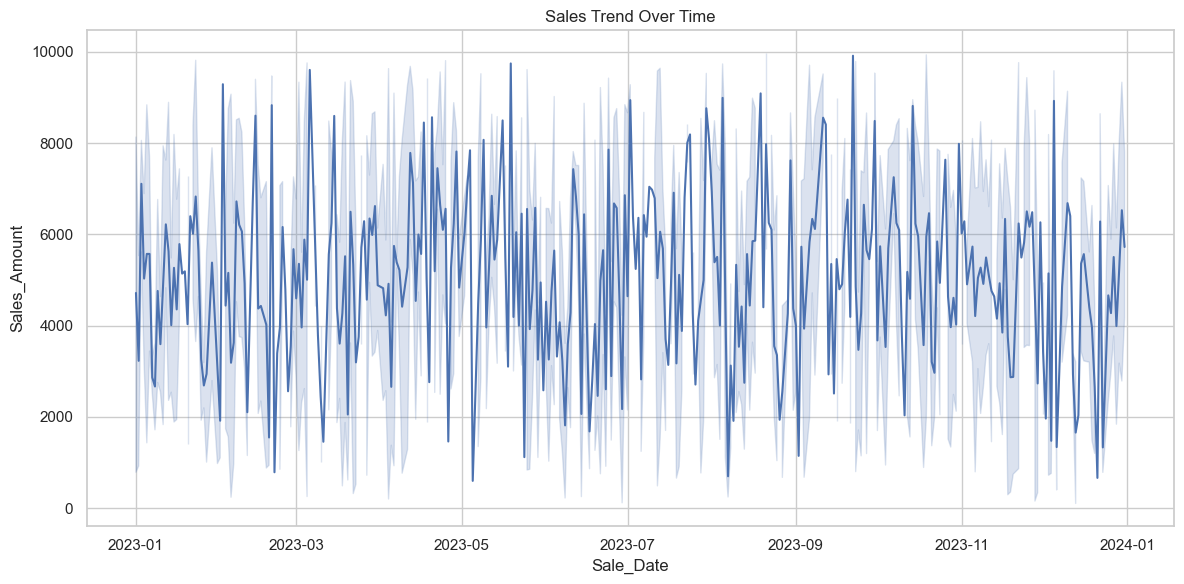

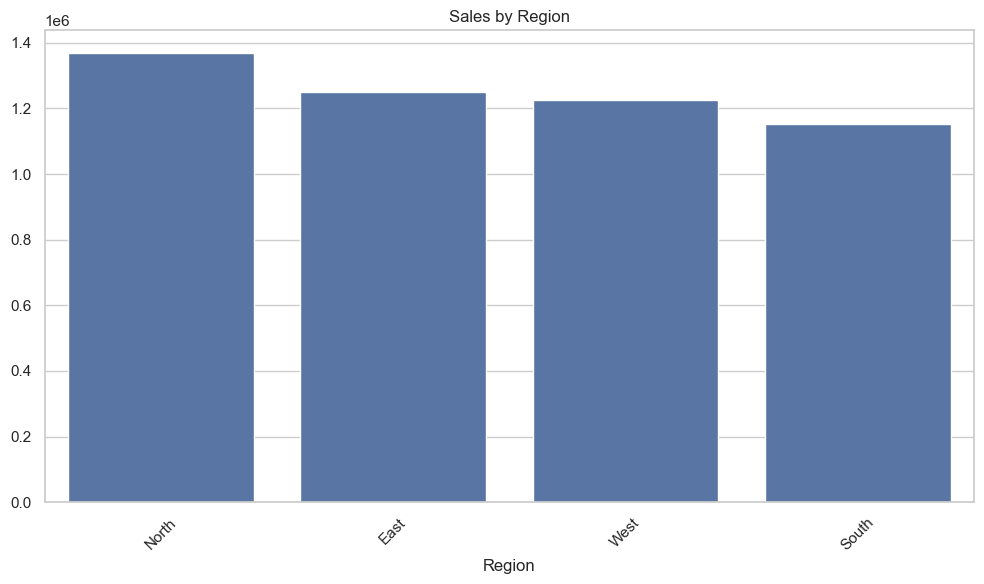

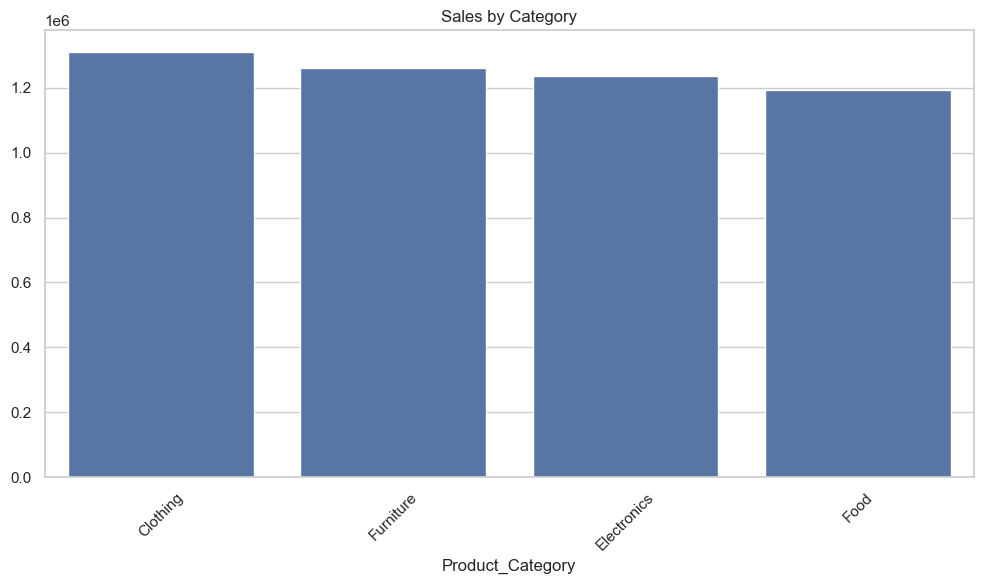

Saved figures: sales_trend.png, sales_by_region.png, sales_by_category.png (if applicable)


In [200]:
# Sales trend over time (aggregate daily to smooth if needed)
try:
    df_sorted = df.sort_values('Sale_Date')
    plt.figure(figsize=(12,6))
    sns.lineplot(x='Sale_Date', y='Sales_Amount', data=df_sorted)
    plt.title('Sales Trend Over Time')
    plt.tight_layout()
    plt.savefig('sales_trend.png')
    plt.show()
    plt.close()
except Exception as e:
    print('Could not produce sales trend plot:', e)

# Sales by region
if 'Region' in df.columns:
    region_sums = df.groupby('Region')['Sales_Amount'].sum().sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=region_sums.index, y=region_sums.values)
    plt.title('Sales by Region')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('sales_by_region.png')
    plt.show()
    plt.close()

# Sales by category
if 'Product_Category' in df.columns:
    cat_sums = df.groupby('Product_Category')['Sales_Amount'].sum().sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=cat_sums.index, y=cat_sums.values)
    plt.title('Sales by Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('sales_by_category.png')
    plt.show()
    plt.close()

print('Saved figures: sales_trend.png, sales_by_region.png, sales_by_category.png (if applicable)')

## Time-series aggregation (monthly) and ExponentialSmoothing forecast (next 12 months)

Forecast for Next 12 Months:


2024-01-31    417391.246984
2024-02-29    417363.821752
2024-03-31    417336.396520
2024-04-30    417308.971288
2024-05-31    417281.546056
2024-06-30    417254.120824
2024-07-31    417226.695592
2024-08-31    417199.270360
2024-09-30    417171.845128
2024-10-31    417144.419896
2024-11-30    417116.994664
2024-12-31    417089.569432
Freq: ME, dtype: float64

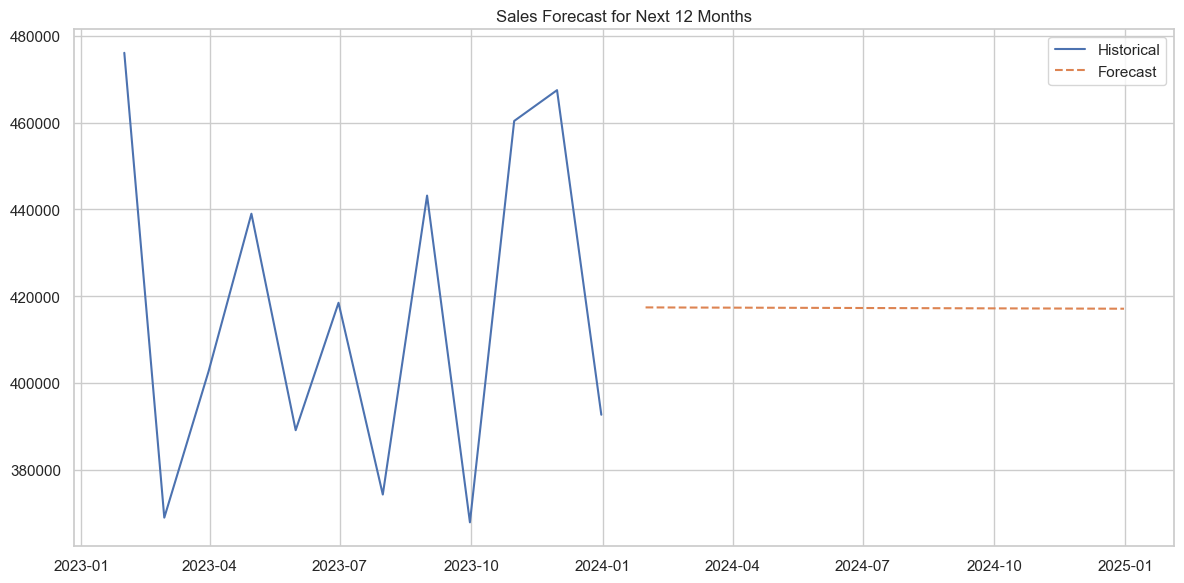

Saved forecast to sales_forecast.csv and sales_forecast.png


In [201]:
# Aggregate by month
monthly_sales = df.groupby(pd.Grouper(key='Sale_Date', freq='M'))['Sales_Amount'].sum()
# Ensure continuous monthly index to avoid model issues
if len(monthly_sales) == 0:
    raise ValueError('No monthly sales data available for forecasting')
monthly_sales = monthly_sales.sort_index()
all_months = pd.date_range(start=monthly_sales.index.min(), end=monthly_sales.index.max(), freq='M')
monthly_sales = monthly_sales.reindex(all_months, fill_value=0)

# Fit ExponentialSmoothing
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal=None, initialization_method='estimated')
fit = model.fit(optimized=True)
forecast = fit.forecast(12)
print('Forecast for Next 12 Months:')
display(forecast)

# Plot historical + forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Historical')
plt.plot(forecast.index, forecast.values, label='Forecast', linestyle='--')
plt.title('Sales Forecast for Next 12 Months')
plt.legend()
plt.tight_layout()
plt.savefig('sales_forecast.png')
plt.show()
plt.close()
# Save forecast to CSV
forecast_df = forecast.rename('Forecast').to_frame()
forecast_df.to_csv('sales_forecast.csv')
print('Saved forecast to sales_forecast.csv and sales_forecast.png')

## Diagnostic analytics — correlation heatmap and numeric diagnostics

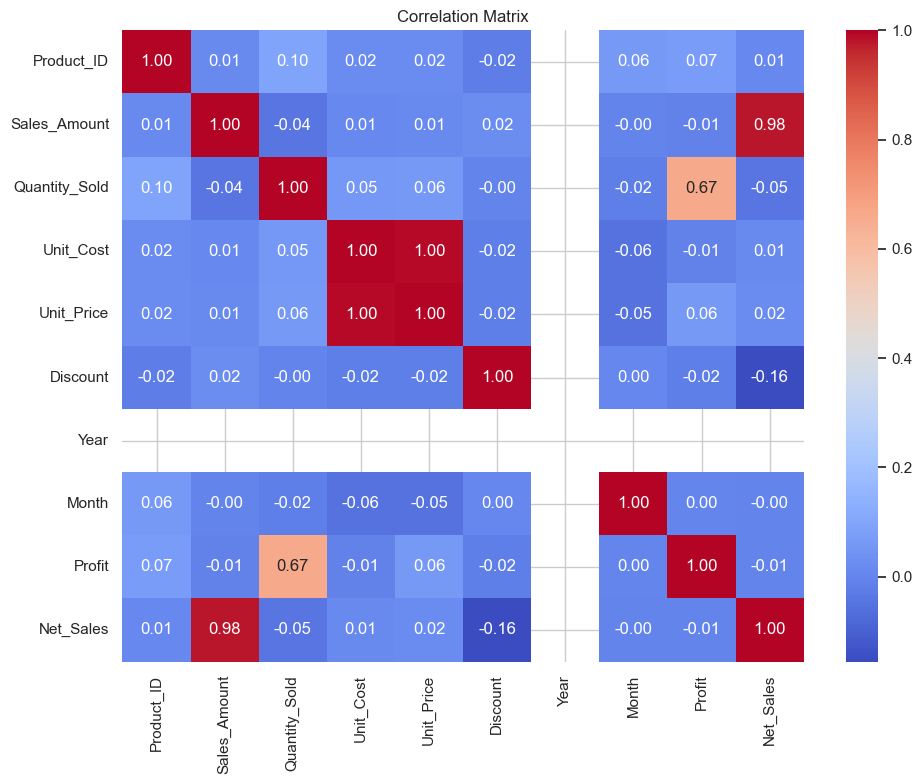

Saved correlation_matrix.png
Missing values per column:
Product_ID              0
Sale_Date               0
Sales_Rep               0
Region                  0
Sales_Amount            0
Quantity_Sold           0
Product_Category        0
Unit_Cost               0
Unit_Price              0
Customer_Type           0
Discount                0
Payment_Method          0
Sales_Channel           0
Region_and_Sales_Rep    0
Year                    0
Month                   0
Profit                  0
Net_Sales               0
dtype: int64
Skewness:


Product_ID       0.029142
Sales_Amount     0.005845
Quantity_Sold    0.001262
Unit_Cost        0.022761
Unit_Price       0.020729
Discount        -0.056604
Year             0.000000
Month           -0.029805
Profit           0.873798
Net_Sales        0.087485
dtype: float64

Kurtosis:


Product_ID      -1.214152
Sales_Amount    -1.203182
Quantity_Sold   -1.201601
Unit_Cost       -1.191975
Unit_Price      -1.187805
Discount        -1.224385
Year             0.000000
Month           -1.254300
Profit          -0.067855
Net_Sales       -1.090505
dtype: float64

In [202]:
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] > 0:
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()
    plt.close()
    print('Saved correlation_matrix.png')
else:
    print('No numeric columns available for correlation matrix')

# Missing values summary
print('Missing values per column:')
print(df.isnull().sum())

# Skewness/kurtosis
try:
    print('Skewness:')
    display(numeric_df.skew())
    print('Kurtosis:')
    display(numeric_df.kurtosis())
except Exception:
    pass

## Regression-based prediction — train/test split, LinearRegression, metrics, residuals

Regression Model Evaluation: RMSE: 2811.3074 MAE: 2453.5789 R²: 0.0047


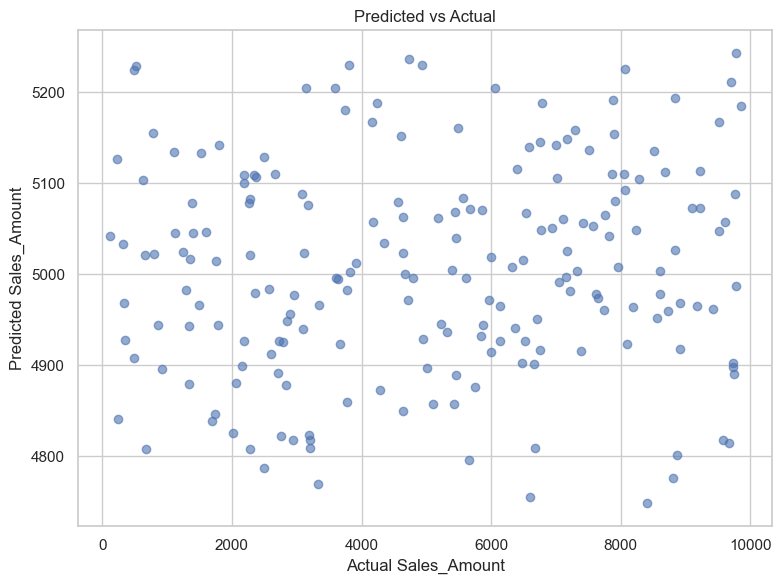

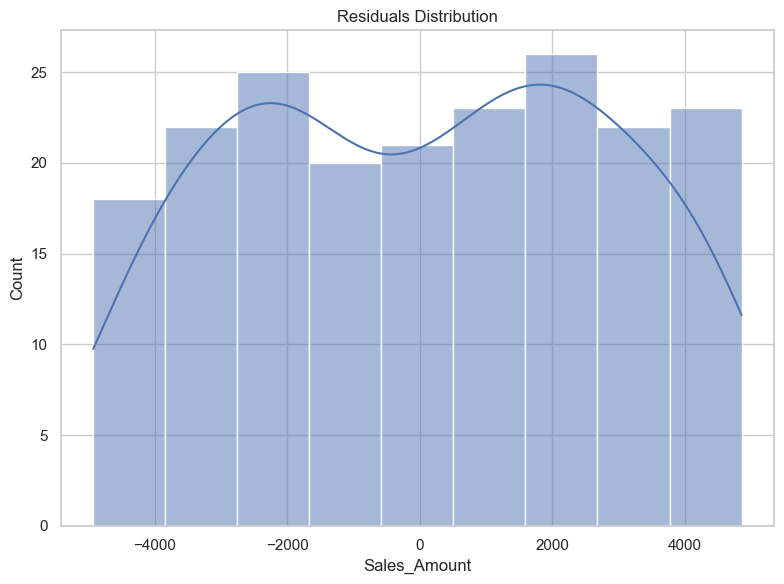

Saved predicted_vs_actual.png, residuals_distribution.png, regression_metrics.txt


In [203]:
# Prepare features
required_features = ['Quantity_Sold','Discount']
for col in required_features:
    if col not in df.columns:
        df[col] = 0

X = df[required_features].fillna(0)
y = df['Sales_Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Regression Model Evaluation: RMSE: {rmse:.4f} MAE: {mae:.4f} R²: {r2:.4f}')

# Plot predicted vs actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Sales_Amount')
plt.ylabel('Predicted Sales_Amount')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.savefig('predicted_vs_actual.png')
plt.show()
plt.close()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.tight_layout()
plt.savefig('residuals_distribution.png')
plt.show()
plt.close()

# Save regression metrics to text file
with open('regression_metrics.txt', 'w') as f:
    f.write(f'RMSE: {rmse} MAE: {mae} R2: {r2} ')

print('Saved predicted_vs_actual.png, residuals_distribution.png, regression_metrics.txt')

## Save outputs and artifacts (cleaned CSV, forecast CSV, regression metrics, figures)

In [204]:
cleaned_path = 'cleaned_sales_data.csv'
df.to_csv(cleaned_path, index=False)
print(f'Saved cleaned data to {cleaned_path}')
# sales_forecast.csv already saved above
print('Saved forecast to sales_forecast.csv')

Saved cleaned data to cleaned_sales_data.csv
Saved forecast to sales_forecast.csv


## Reproducibility & environment cell (random seed, package versions)

In [205]:
print('Package versions:')
import pandas as _pd, numpy as _np, matplotlib as _mpl, seaborn as _sns
import statsmodels as _sm, sklearn as _sk
print('pandas:', _pd.__version__)
print('numpy:', _np.__version__)
print('matplotlib:', _mpl.__version__)
print('seaborn:', _sns.__version__)
print('statsmodels:', _sm.__version__)
print('sklearn:', _sk.__version__)

print('Files created in this run (if successful):')
for fname in ['sales_trend.png','sales_by_region.png','sales_by_category.png','sales_forecast.png','correlation_matrix.png','predicted_vs_actual.png','residuals_distribution.png','regression_metrics.txt','sales_forecast.csv','cleaned_sales_data.csv']:
    print('-', fname, '->', os.path.exists(fname))

Package versions:
pandas: 2.3.2
numpy: 2.3.2
matplotlib: 3.10.6
seaborn: 0.13.2
statsmodels: 0.14.5
sklearn: 1.7.1
Files created in this run (if successful):
- sales_trend.png -> True
- sales_by_region.png -> True
- sales_by_category.png -> True
- sales_forecast.png -> True
- correlation_matrix.png -> True
- predicted_vs_actual.png -> True
- residuals_distribution.png -> True
- regression_metrics.txt -> True
- sales_forecast.csv -> True
- cleaned_sales_data.csv -> True


In [206]:
print('Analysis complete.')

Analysis complete.
